# Visualizing Flow around an Airfoil Using Python

The notebook explains the data visualization procedure for a [Tecplot DAT format file](https://www.tecplot.com/2018/09/19/comparison-of-tecplot-data-file-formats/), including:
- Data extraction
- Coutour plots for a given slice position
- Animation

## Load module and set parameters

In [1]:
import re
import math
import pdb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
data_path = '../data/single-flo.10000.dat'
airfoil_path = '../data/airfoil'
z_slice = 0.0125 # slice position to study (z in spanwise direction)
scale =  20 # zoom-in scale applied to plots
alpha = 8 # angle of attack
Nx = 200 # data point number in x direction
Ny = 100 # data point number in y direction

## Define utility functions

In [3]:
# load flow field data file
def readAirfoil(path):
    if not os.path.isfile(path):
        print('file does not exist')
        return
    file_in = open(path,'r')
    x = []
    y = []
    for line in file_in:
        x.append(float(line.split()[0]))
        y.append(float(line.split()[1]))
    return x, y

In [4]:
# load flow field data file
def loadData(path, z_slice):
    eps = 1E-5
    if not os.path.isfile(path):
        print('file does not exist')
        return
    file_in=open(path,'r')
    solution = []
    for line in file_in:
        if re.match("  [ -]0",line) and len(re.split('\s+|,',line)) >= 3 \
            and float(re.split('\s+|,',line)[3]) >= z_slice - eps \
            and float(re.split('\s+|,',line)[3]) <= z_slice + eps:
            solution.append([float(i) for i in re.split('\s+|,',line)[1:10]])
    df_solution = pd.DataFrame(solution, columns=['x','y','z','r','ru','rv','rw','re','p'])
    df_solution.drop_duplicates(inplace=True) # data points could be duplicated on the internal block boundaries, removal needed 
    df_solution['velocity'] = np.sqrt((df_solution['ru']/df_solution['r'])**2 + (df_solution['rv']/df_solution['r'])**2)
    return df_solution[['x','y','velocity']]

In [5]:
# Calculation of geometric properties of boundary element segments
def geometry(x_list,y_list,seg_list):
    Ns = np.sum(seg_list) # total no. of segments
    Np = Ns+1 # total no. of segment end-points
    
    lb = np.sqrt((x_list[1:]-x_list[:-1])**2 + (y_list[1:]-y_list[:-1])**2)

    # total no. of segments at the beginning of each boundary element
    seg_num = [0 for _ in range(seg_list.size)]
    for i in range(1,seg_list.size):
        seg_num[i] = seg_num[i-1] + seg_list[i-1]

    x, y = [np.zeros(Np) for i in range(2)]
    x[0] = x[-1] = x_list[0]; y[0] = y[-1] = y_list[0]
    for i in range(seg_list.size):
        x[seg_num[i]:seg_num[i]+seg_list[i]+1] = np.linspace(x_list[i],x_list[i+1],seg_list[i]+1)
        y[seg_num[i]:seg_num[i]+seg_list[i]+1] = np.linspace(y_list[i],y_list[i+1],seg_list[i]+1)

    # mid-pt of segments
    xm = 0.5*(x[1:] + x[:-1])
    ym = 0.5*(y[1:] + y[:-1])

    # list of mid-pts by boundary element index
    xms, yms = [[0]*seg_list.size for i in range(2)] # sequence with 1 element for each segment 
    for i in range(seg_list.size):
        xms[i] = np.array(xm[seg_num[i]:seg_num[i]+seg_list[i]])
        yms[i] = np.array(ym[seg_num[i]:seg_num[i]+seg_list[i]])

    # length of segments
    l = np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)

    # normal vectors
    ny = (x[:-1] - x[1:])/l
    nx = (y[1:] - y[:-1])/l        

    return x, y, xm, ym, xms, yms, nx, ny, l, Ns, seg_num, lb

An airfoil could be a concave polygon as is the SD7003 airfoil. Ray casting algorithm could be used to determine is a given point is inside the polygon.

In [6]:
# Function used to decide if a data point is inside the airfoil
# Use Ray casting algorithm to determine if a point is inside a polygon
def isInsidePolygon(p, poly):
    ans = False
    i = -1
    l = len(poly)
    j = l - 1
    while i < l - 1:
        i += 1
        if ((poly[i][0] <= p[0] and p[0] < poly[j][0]) or (
                poly[j][0] <= p[0] and p[0] < poly[i][0])):
            if (p[1] < (poly[j][1] - poly[i][1]) * (p[0] - poly[i][0]) / (
                poly[j][0] - poly[i][0]) + poly[i][1]):
                ans = not ans
        j = i
    return ans

## Data loading and numerical setup

Let's take a look at the flow field solution data

In [7]:
df_focus = loadData(data_path, z_slice)
df_focus.head()

,x,y,velocity
0,40.00000,0.0,1.000286
1,39.75454,0.0,1.000322
2,39.50659,0.0,1.000373
3,39.25615,0.0,1.000424
4,39.00317,0.0,1.000474


In [8]:
df_focus.describe()

,x,y,velocity
count,135874.000000,135874.000000,135874.000000
mean,8.702162,0.002796,0.985908
std,12.013506,5.669050,0.126423
min,-20.000000,-20.000000,0.000000
25%,0.804687,-0.872142,0.983914
50%,2.655317,0.000195,1.000224
75%,13.637720,0.889656,1.004403
max,40.000000,20.000000,2.032671


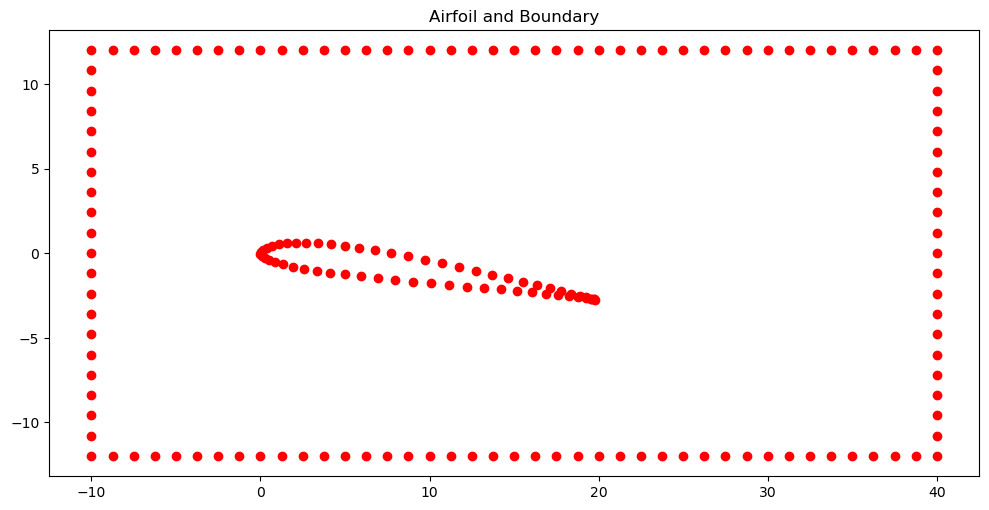

In [9]:
# Set the external boundary and the internal bounday (airfoil)
# End-point coordinates of external rectangular domain (anti-clockwise / last pt = first pt)
x_list1 = np.array([-10.,40.,40.,-10.,-10.])
y_list1 = np.array([-12.,-12.,12,12,-12])
# No. of segments for each boundary element
seg_list1 = np.array([40,20,40,20])

# Coordinates of airfoil (clockwise / last pt = first pt)
x_list2, y_list2 = readAirfoil(airfoil_path)
x_list2 = scale*np.array(x_list2)[::-1] # clockwise
y_list2 = scale*np.array(y_list2)[::-1] # clockwise
D2R = np.pi/180
rot = np.array([np.cos(alpha*D2R), -np.sin(alpha*D2R), np.sin(alpha*D2R), np.cos(alpha*D2R)]).reshape(2,2) # rotation matrix
x_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,0] # rotate airfoil according to alpha
y_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,1]
Ns2 = x_list2.size - 1
seg_list2 = np.array([1 for _ in range(Ns2)])
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

x1, y1, xm1, ym1, xms1, yms1, nx1, ny1, l1, Ns1, seg_num1, lb1 = geometry(x_list1,y_list1,seg_list1)
x2, y2, xm2, ym2, xms2, yms2, nx2, ny2, l2, Ns2, seg_num2, lb2 = geometry(x_list2,y_list2,seg_list2)

# Combining the internal & external boundaries
x = np.append(x1[:-1],x2[:-1])
y = np.append(y1[:-1],y2[:-1])
xm = np.append(xm1,xm2)
ym = np.append(ym1,ym2)
l = np.append(l1,l2)
nx = np.append(nx1,nx2)
ny = np.append(ny1,ny2)
Ns = Ns1 + Ns2
seg_list = np.append(seg_list1,seg_list2)
seg_num = np.zeros(seg_list.size)
for i in range(1,seg_list.size):
    seg_num[i] = seg_num[i-1] + seg_list[i-1]

fig = plt.figure(figsize=(12,12),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.scatter(x,y,c=u'r',marker=u'o')
plt.title('Airfoil and Boundary')
plt.show()

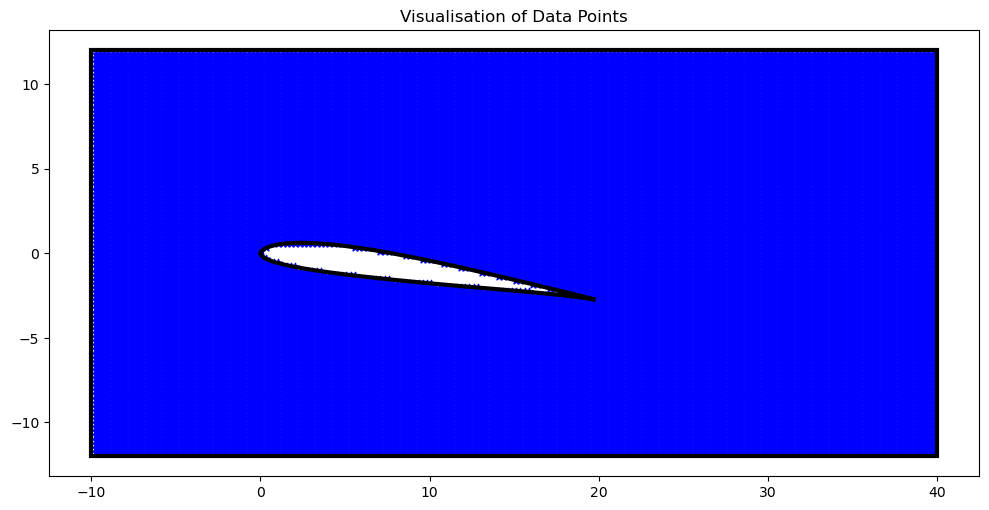

In [10]:
# make grids with uniformly distributed data points
%matplotlib inline

X = np.linspace(x.min(),x.max(),Nx)
Y = np.linspace(y.min(),y.max(),Ny)
X,Y = np.meshgrid(X[1:-1],Y[1:-1])
X = X.ravel(); Y = Y.ravel()

# Determines if a data point are inside the airfoil region using Ray casting algorithm
# If so, set the velocity on the data points to be 0, and append the data points to the flow field solution DataFrame
D = np.zeros((X.size,xm2.size))
L = np.zeros((X.size,xm2.size))
I = []
for i in range(X.size):
    if isInsidePolygon([X[i],Y[i]], np.c_[x_list2,y_list2]):
        df_focus = df_focus.append({'x': X[i], 'y': Y[i], 'velocity':0.0}, ignore_index=True)
        I.append(i)

X = np.delete(X.ravel(),I)
Y = np.delete(Y.ravel(),I)

fig = plt.figure(figsize=(12,12),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.fill(x1,y1,fill=False,lw=3)
plt.fill(x2,y2,fill=False,lw=3)
plt.scatter(X,Y,c=u'b',marker=u'*')
plt.title('Visualisation of Data Points')
plt.show()

Recalling that we did rotation of airfoil geometry data according to the angle of attack. Same procedure need to be executed for the flow field solution data.

In [11]:
coord = df_focus[['x','y']].values
df_focus[['x','y']] = np.dot(coord,rot)
df_focus.head()

,x,y,velocity
0,39.610723,-5.566924,1.000286
1,39.367652,-5.532763,1.000322
2,39.122115,-5.498255,1.000373
3,38.874112,-5.463400,1.000424
4,38.623594,-5.428192,1.000474


## Instantaneous contour plots

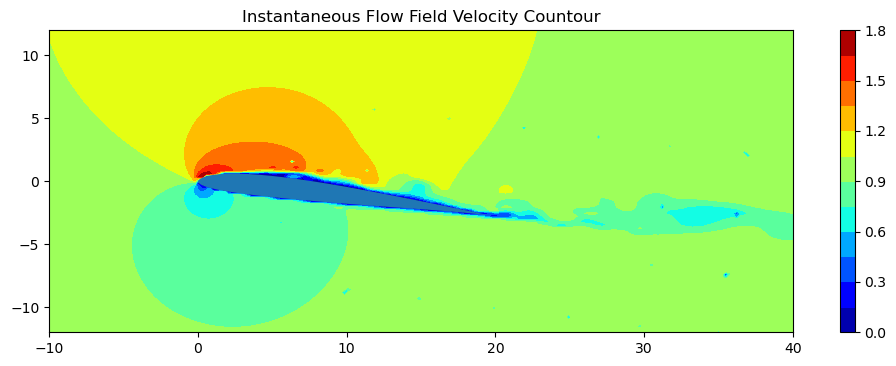

In [12]:
# interpolation
xi = np.linspace(x.min(),x.max(),Nx)
yi = np.linspace(y.min(),y.max(),Ny)
zi = griddata((scale*df_focus['x'], scale*df_focus['y']), df_focus['velocity'], (xi[None,:], yi[:,None]), method='linear')

fig = plt.figure(figsize=(12,4),dpi=100)
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.fill(x2,y2,fill=True, lw=3)
plt.colorbar() # draw colorbar
plt.xlim(-10,40)
plt.ylim(-12,12)
plt.title('Instantaneous Flow Field Velocity Countour')
plt.show()

## Animation

First build the whole pipeline for instantaneous flow field extraction at each time step.

Concatenate all solution in a series